# TODO:

        1) BERT transfer learning
        2) train unique RNN? ehhhhh
        3) which countries most accurate in?
        4) what words are appearing in mislabeled tweets?
        5) further location cleaning / explanations for tfidf and count (and f1/precision/recall)

In [213]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import re 
import string
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from wordcloud import WordCloud
import chart_studio.plotly as py
import plotly.graph_objects as go
from plotly.offline import download_plotlyjs, plot, iplot
import plotly.express as px
import plotly.figure_factory as ff
from plotly.colors import n_colors
from plotly.subplots import make_subplots

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import os
from os import path

In [214]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/cam/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [215]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/cam/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [216]:
# Load in training data
train = pd.read_csv('Corona_NLP_train.csv', encoding = 'latin1')
# Copy training data
df = train.copy()
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [217]:
# Load in test data
test_df = pd.read_csv('Corona_NLP_test.csv', encoding = 'latin1')
test_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


## 2) Data Cleaning


In [218]:
# Check for nulls
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [219]:
# Replace na with 'None'
df['Location'].fillna('None', inplace = True)
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,None,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,None,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [220]:
# Join stopwords together and set them for use in cleaning function.
", ".join(stopwords.words('english'))
stops = set(stopwords.words('english'))

# Function that cleans tweets for classification. 
def clean_tweet(tweet):
    # Remove hyperlinks.
    tweet= re.sub(r'https?://\S+|www\.\S+','',tweet)
    # Remove html
    tweet = re.sub(r'<.*?>','',tweet)
    # Remove numbers (Do we want to remove numbers? Death toll?)
    tweet = re.sub(r'\d+','',tweet)
    # Remove mentions
    tweet = re.sub(r'@\w+','',tweet)
    # Remove punctuation
    tweet = re.sub(r'[^\w\s\d]','',tweet)
    # Remove whitespace
    tweet = re.sub(r'\s+',' ',tweet).strip()
    # Remove stopwords
    tweet = " ".join([word for word in str(tweet).split() if word not in stops])
    
    return tweet.lower()

In [221]:
# Check function
example2 = df['OriginalTweet'][1]
clean_tweet(example2)

'advice talk neighbours family exchange phone numbers create contact list phone numbers neighbours schools employer chemist gp set online shopping accounts poss adequate supplies regular meds order'

In [222]:
# Apply text cleaning function to training and test dataframes.
df['newTweet'] = df['OriginalTweet'].apply(lambda x: clean_tweet(x))
test_df['newTweet'] = test_df['OriginalTweet'].apply(lambda x: clean_tweet(x))
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,newTweet
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,advice talk neighbours family exchange phone n...
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,coronavirus australia woolworths give elderly ...
3,3802,48754,None,16-03-2020,My food stock is not the only one which is emp...,Positive,my food stock one empty please dont panic ther...
4,3803,48755,None,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,me ready go supermarket covid outbreak not im ...


In [223]:
def token_stem(tweet):
    tk = TweetTokenizer()
    stemmer = PorterStemmer()
    tweet = tk.tokenize(tweet)
    tweet = [stemmer.stem(word) for word in tweet]
    tweet =  tweet = " ".join([word for word in tweet])
    return tweet

In [224]:
def token_lemma(tweet):
    tk = TweetTokenizer()
    lemma = WordNetLemmatizer()
    tweet = tk.tokenize(tweet)
    tweet = [lemma.lemmatize(word) for word in tweet]
    tweet = " ".join([word for word in tweet])
    return tweet

In [225]:
tweet = df['newTweet'][1]
tweet

'advice talk neighbours family exchange phone numbers create contact list phone numbers neighbours schools employer chemist gp set online shopping accounts poss adequate supplies regular meds order'

In [226]:
print(token_stem(tweet))
print('\n')
print(token_lemma(tweet))

advic talk neighbour famili exchang phone number creat contact list phone number neighbour school employ chemist gp set onlin shop account poss adequ suppli regular med order


advice talk neighbour family exchange phone number create contact list phone number neighbour school employer chemist gp set online shopping account po adequate supply regular med order


In [227]:
df['stemTweet'] = df['newTweet'].apply(lambda x: token_stem(x))
df['lemmaTweet'] = df['newTweet'].apply(lambda x: token_lemma(x))
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,newTweet,stemTweet,lemmaTweet
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,,,
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,advice talk neighbours family exchange phone n...,advic talk neighbour famili exchang phone numb...,advice talk neighbour family exchange phone nu...
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,coronavirus australia woolworths give elderly ...,coronaviru australia woolworth give elderli di...,coronavirus australia woolworth give elderly d...
3,3802,48754,None,16-03-2020,My food stock is not the only one which is emp...,Positive,my food stock one empty please dont panic ther...,my food stock one empti pleas dont panic there...,my food stock one empty please dont panic ther...
4,3803,48755,None,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,me ready go supermarket covid outbreak not im ...,me readi go supermarket covid outbreak not im ...,me ready go supermarket covid outbreak not im ...


In [228]:
# Create more useful labels for classification.
# We will take the original 5 possibilites and
# reduce them to 3, removing the "extremelys".
def make_label(sentiment):
    
    label = ''
    if 'Positive' in sentiment: 
        label = 1
    if 'Negative' in sentiment:
        label = -1
    if 'Neutral' in sentiment:
        label = 0
    return label

In [229]:
# Apply make_label funtion to training and test dataframes.
df['label'] = df['Sentiment'].apply(lambda x: make_label(x))
test_df['label'] = test_df['Sentiment'].apply(lambda x: make_label(x))
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,newTweet,stemTweet,lemmaTweet,label
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,,,,0
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,advice talk neighbours family exchange phone n...,advic talk neighbour famili exchang phone numb...,advice talk neighbour family exchange phone nu...,1
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,coronavirus australia woolworths give elderly ...,coronaviru australia woolworth give elderli di...,coronavirus australia woolworth give elderly d...,1
3,3802,48754,None,16-03-2020,My food stock is not the only one which is emp...,Positive,my food stock one empty please dont panic ther...,my food stock one empti pleas dont panic there...,my food stock one empty please dont panic ther...,1
4,3803,48755,None,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,me ready go supermarket covid outbreak not im ...,me readi go supermarket covid outbreak not im ...,me ready go supermarket covid outbreak not im ...,-1


In [230]:
# Some frequent US locations
us_filters = ('New York', 'New York, NY', 'NYC', 'NY', 'Washington, DC', 'Los Angeles, CA',
             'Seattle, Washington', 'Chicago', 'Chicago, IL', 'California, USA', 'Atlanta, GA',
             'San Francisco, CA', 'Boston, MA', 'New York, USA', 'Texas, USA', 'Austin, TX',
              'Houston, TX', 'New York City', 'Philadelphia, PA', 'Florida, USA', 'Seattle, WA',
             'Washington, D.C.', 'San Diego, CA', 'Las Vegas, NV', 'Dallas, TX', 'Denver, CO',
             'New Jersey, USA', 'Brooklyn, NY', 'California', 'Michigan, USA', 'Minneapolis, MN',
             'Virginia, USA', 'Miami, FL', 'Texas', 'Los Angeles', 'United States', 'San Francisco',
             'Indianapolis, IN', 'Pennsylvania, USA', 'Phoenix, AZ', 'New Jersey', 'Baltimore, MD',
             'CA', 'FL', 'DC', 'TX', 'IL', 'MA', 'PA', 'GA', 'NC', 'NJ', 'WA', 'VA', 'PAK', 'MI', 'OH',
             'CO', 'AZ', 'D.C.', 'WI', 'MD', 'MO', 'TN', 'Florida', 'IN', 'NV', 'MN', 'OR','LA', 'Michigan',
             'CT', 'SC', 'OK', 'Illinois', 'Ohio', 'UT', 'KY', 'Arizona', 'Colorado')

# Various nation's frequent locations
uk_filters = ('England', 'London', 'london', 'United Kingdom', 'united kingdom',
              'England, United Kingdom', 'London, UK', 'London, England',
              'Manchester, England', 'Scotland, UK', 'Scotland', 'Scotland, United Kingdom',
              'Birmingham, England', 'UK', 'Wales')
india_filters = ('New Delhi, India', 'Mumbai', 'Mumbai, India', 'New Delhi', 'India', 
                 'Bengaluru, India')
australia_filters = ('Sydney, Australia', 'New South Wales', 'Melbourne, Australia', 'Sydney',
                     'Sydney, New South Wales', 'Melbourne, Victoria', 'Melbourne', 'Australia')
canada_filters = ('Toronto, Ontario', 'Toronto', 'Ontario, Canada', 'Toronto, Canada', 'Canada',
                  'Vancouver, British Columbia', 'Ontario', 'Victoria', 'British Columbia', 'Alberta',)
south_africa_filters = ('Johannesburg, South Africa', 'Cape Town, South Africa', 'South Africa')
nigeria_filters = ('Lagos, Nigeria')
kenya_filters = ('Nairobi, Kenya')
france_filters = ('Paris, France')
ireland_filters = ('Ireland')
new_zealand_filters = ('New Zealand')
pakistan_filters = ('Pakistan')
malaysia_filters = ('Malaysia')
uganda_filters = ('Kampala, Uganda', 'Uganda')
singapore_filters = ('Singapore')
germany_filters = ('Germany', 'Deutschland')
switz_filters = ('Switzerland')
uae_filters = ('United Arab Emirates', 'Dubai')
spain_filters = ('Spain')
belg_filters = ('Belgium')
phil_filters = ('Philippines')
hk_filters = ('Hong Kong')
ghana_filters = ('Ghana')
# These all have large counts. Need to be removed from rest of data
other_filters = ('None', 'Worldwide', 'Global', 'Earth', '??')

In [231]:
df['country'] = df['Location'].apply(lambda x: x.split(",")[-1].strip() if ("," in x) else x)

In [232]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,newTweet,stemTweet,lemmaTweet,label,country
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,,,,0,London
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,advice talk neighbours family exchange phone n...,advic talk neighbour famili exchang phone numb...,advice talk neighbour family exchange phone nu...,1,UK
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,coronavirus australia woolworths give elderly ...,coronaviru australia woolworth give elderli di...,coronavirus australia woolworth give elderly d...,1,Vagabonds
3,3802,48754,None,16-03-2020,My food stock is not the only one which is emp...,Positive,my food stock one empty please dont panic ther...,my food stock one empti pleas dont panic there...,my food stock one empty please dont panic ther...,1,None
4,3803,48755,None,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,me ready go supermarket covid outbreak not im ...,me readi go supermarket covid outbreak not im ...,me ready go supermarket covid outbreak not im ...,-1,None


In [233]:
# Changing strings found with filters into 3 digit codes
df['country'] = df['country'].apply(lambda x: 'USA' if x in us_filters else x)
df['country'] = df['country'].apply(lambda x: 'GBR' if x in uk_filters else x)
df['country'] = df['country'].apply(lambda x: 'IND' if x in india_filters else x)
df['country'] = df['country'].apply(lambda x: 'AUS' if x in australia_filters else x)
df['country'] = df['country'].apply(lambda x: 'CAN' if x in canada_filters else x)
df['country'] = df['country'].apply(lambda x: 'ZAF' if x in south_africa_filters else x)
df['country'] = df['country'].apply(lambda x: 'KEN' if x in kenya_filters else x)
df['country'] = df['country'].apply(lambda x: 'NGA' if x in nigeria_filters else x)
df['country'] = df['country'].apply(lambda x: 'SGP' if x in singapore_filters else x)
df['country'] = df['country'].apply(lambda x: 'FRA' if x in france_filters else x)
df['country'] = df['country'].apply(lambda x: 'NZL' if x in new_zealand_filters else x)
df['country'] = df['country'].apply(lambda x: 'PAK' if x in pakistan_filters else x)
df['country'] = df['country'].apply(lambda x: 'MYS' if x in malaysia_filters else x)
df['country'] = df['country'].apply(lambda x: 'IRL' if x in ireland_filters else x)
df['country'] = df['country'].apply(lambda x: 'UGA' if x in uganda_filters else x)
df['country'] = df['country'].apply(lambda x: 'DEU' if x in germany_filters else x)
df['country'] = df['country'].apply(lambda x: 'CHE' if x in switz_filters else x)
df['country'] = df['country'].apply(lambda x: 'ARE' if x in uae_filters else x)
df['country'] = df['country'].apply(lambda x: 'ESP' if x in spain_filters else x)
df['country'] = df['country'].apply(lambda x: 'BEL' if x in belg_filters else x)
df['country'] = df['country'].apply(lambda x: 'PHL' if x in phil_filters else x)
df['country'] = df['country'].apply(lambda x: 'GHA' if x in ghana_filters else x)
df['country'] = df['country'].apply(lambda x: 'HKG' if x in hk_filters else x)
df['country'] = df['country'].apply(lambda x: 'None' if x in other_filters else x)

In [234]:
df['country'].value_counts()

USA                    9675
None                   8980
GBR                    3811
CAN                    1233
IND                    1097
                       ... 
Chicago to Colorado       1
Alliston                  1
save us                   1
DMV by way of Ohio        1
4th planet from sun       1
Name: country, Length: 7313, dtype: int64

In [235]:
# 0:24 because that's where the labeled countries end
places_df = pd.DataFrame(df['country'].value_counts()[0:30])
places_df.reset_index(inplace = True)
places_df.rename(columns = {'index':'Country', 'country':'Tweets'}, inplace = True)
# Remove 'None' location
places_df = places_df[places_df['Country'] != 'None']

In [236]:
data = dict(type='choropleth',
            colorscale = 'inferno',
            locations = places_df['Country'],
            z = places_df['Tweets'],
            #locationmode = 'USA-states',
            text = places_df['Tweets'],
            marker = dict(line = dict(color = 'rgb(255,255,255)',width = 2)),
            colorbar = {'title':"Number of Tweets"}
            ) 

layout = dict(title = 'Number of Tweets By Country',
              geo = dict(#scope='usa',
                         showlakes = False,
                         lakecolor = 'rgb(85,173,240)',
                         projection_type='equirectangular')
             )

choromap = go.Figure(data = [data],layout = layout)

In [237]:
iplot(choromap)

In [238]:
# image courtesy of https://tse2.mm.bing.net/th?id=OIP.VLv_PpEOc8TDwuTNvj5hWQHaHa&pid=Api
mask = np.array(Image.open("rona4.jpeg"))

# Positive WordCloud
pos_df = df[df['label'] == 1]
pos_text = pos_df['newTweet'].to_string(index = False)
pos_text = re.sub(r'\n','',pos_text)
pos_cloud = WordCloud(colormap = 'Greens', mask = mask).generate(pos_text)

# Neutral WordCloud
neut_df = df[df['label'] == 0]
neut_text = neut_df['newTweet'].to_string(index = False)
neut_text = re.sub(r'\n','', neut_text)
neut_cloud = WordCloud(colormap = 'Blues', mask = mask).generate(neut_text)

# Negative wordcloud
neg_df = df[df['label'] == -1]
neg_text = neg_df['newTweet'].to_string(index = False)
neg_text = re.sub(r'\n','', neg_text)
neg_cloud = WordCloud(colormap = 'Reds', mask = mask).generate(neg_text)

(-0.5, 473.5, 473.5, -0.5)

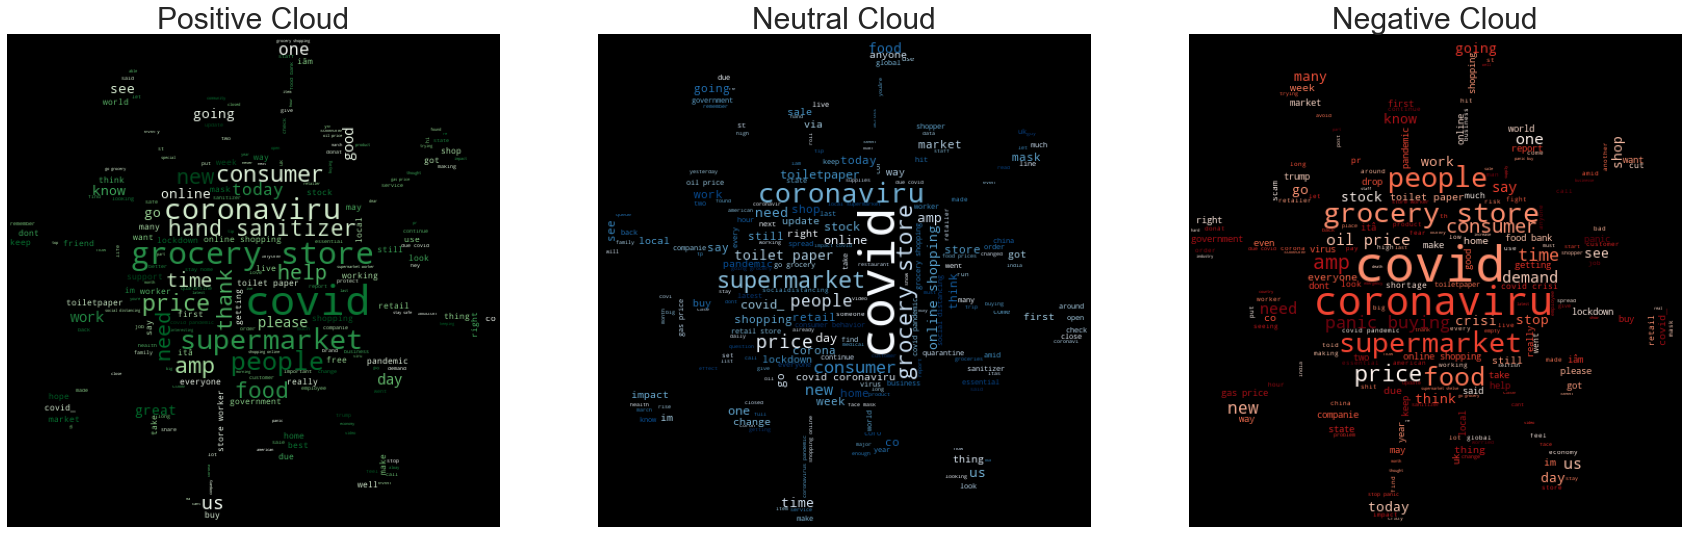

In [239]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = [30,20])
ax1.imshow(pos_cloud)
ax1.set_title('Positive Cloud', fontsize = 30)
ax1.axis('off')
ax2.imshow(neut_cloud)
ax2.set_title('Neutral Cloud', fontsize = 30)
ax2.axis('off')
ax3.imshow(neg_cloud)
ax3.set_title('Negative Cloud', fontsize = 30)
ax3.axis('off')

Tried to use an image of the coronavirus for the mask, it certainly could have turned out better...
'Grocery store', 'price', 'supermarket', and 'online shopping' being frequent in positive, neutral, and negative tweets is interesting.  Some stand-out negative terms are 'panic buying' and 'toilet paper'. For positive, 'hand sanitizer' catches my attention. 

In [240]:
def ngram_df(corpus,nrange,n=None):
    vec = CountVectorizer(stop_words = 'english',ngram_range=nrange).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    total_list=words_freq[:n]
    df=pd.DataFrame(total_list,columns=['text','count'])
    return df

In [241]:
unigram_df = ngram_df(df['newTweet'],(1,1),20)
bigram_df = ngram_df(df['newTweet'],(2,2),20)
trigram_df = ngram_df(df['newTweet'],(3,3),20)

In [242]:
unigram_df['text'][::-1]

19           time
18           like
17      sanitizer
16          panic
15        workers
14           need
13       pandemic
12         covid_
11         online
10       shopping
9        consumer
8             amp
7          people
6         grocery
5           store
4     supermarket
3            food
2          prices
1     coronavirus
0           covid
Name: text, dtype: object

neat plot but seaborn looks better
fig = make_subplots(
    rows=3, cols=1,subplot_titles=("Unigram","Bigram",'Trigram'),
    specs=[[{"type": "scatter"}],
           [{"type": "scatter"}],
           [{"type": "scatter"}]
          ])

fig.add_trace(go.Bar(
    y=unigram_df['text'][::-1],
    x=unigram_df['count'][::-1],
    marker={'color': "blue"},  
    text=unigram_df['count'],
    textposition = "outside",
    orientation="h",
    name="Months",
),row=1,col=1)

fig.add_trace(go.Bar(
    y=bigram_df['text'][::-1],
    x=bigram_df['count'][::-1],
    marker={'color': "blue"},  
    text=bigram_df['count'],
     name="Days",
    textposition = "outside",
    orientation="h",
),row=2,col=1)

fig.add_trace(go.Bar(
    y=trigram_df['text'][::-1],
    x=trigram_df['count'][::-1],
    marker={'color': "blue"},  
    text=trigram_df['count'],
     name="Days",
    orientation="h",
    textposition = "outside",
),row=3,col=1)

fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_layout(title_text='Top N Grams',xaxis_title=" ",yaxis_title=" ", showlegend=False,title_x=0.5,
                  height=1200,template="plotly_dark")
fig.show()


<AxesSubplot:xlabel='count', ylabel='text'>

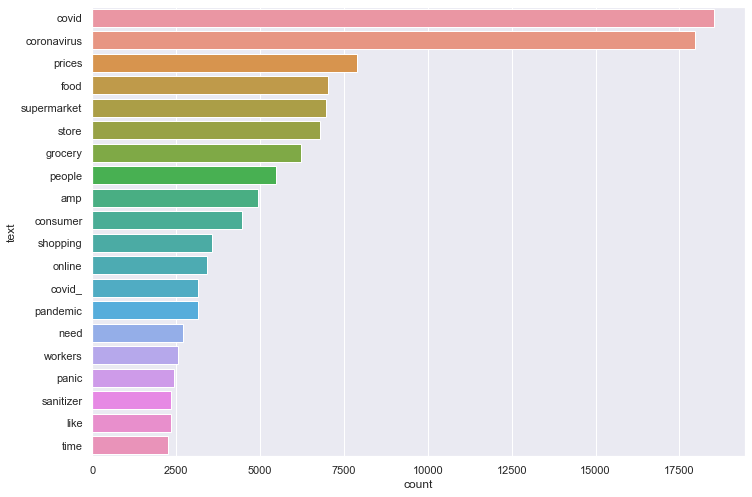

In [243]:
sns.set(font_scale = 1.3)
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(data = unigram_df, y = 'text', x = 'count')

<AxesSubplot:xlabel='count', ylabel='text'>

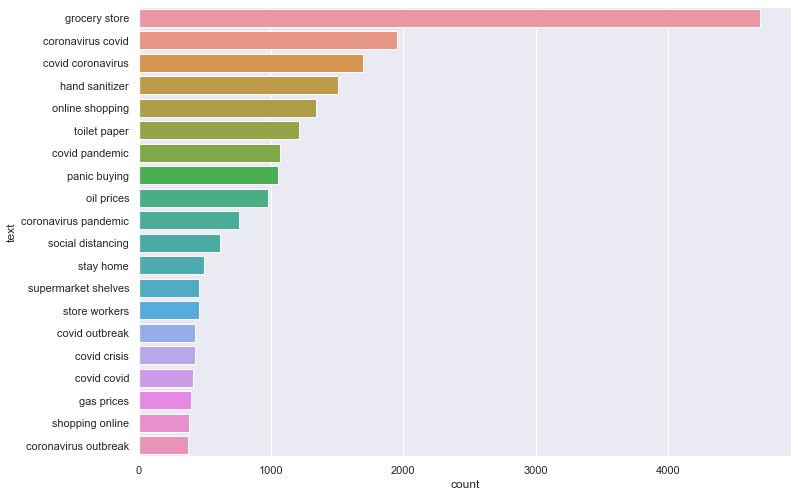

In [244]:
sns.set(font_scale = 1.3)
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(data = bigram_df, y = 'text', x = 'count')

<AxesSubplot:xlabel='count', ylabel='text'>

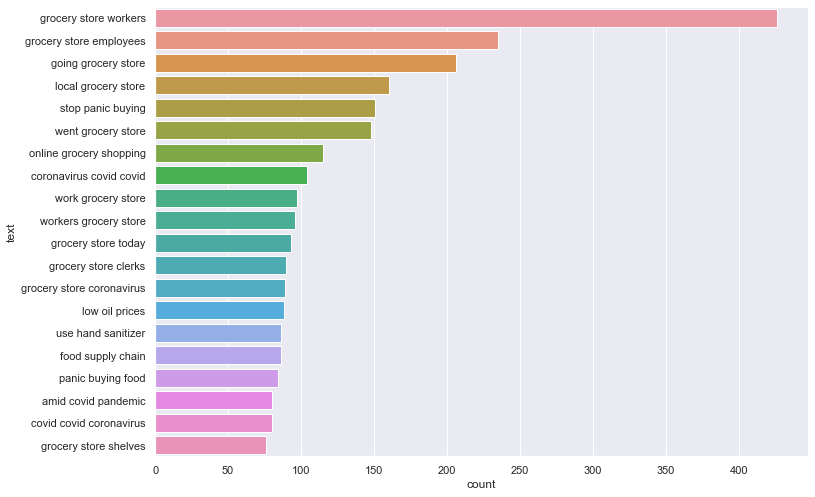

In [245]:
sns.set(font_scale = 1.3)
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(data = trigram_df, y = 'text', x = 'count')

## 4) Classification

In [246]:
# Set X and y.
X = df['newTweet']
y = df['label']

# Split data into training and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [247]:
pipe = Pipeline([('vectorizer',TfidfVectorizer()),
            ('clf', LinearSVC()),
            ])
pipe.fit(X_train, y_train)
preds = pipe.predict(X_test)

In [248]:
clf = dict({'SVC': LinearSVC(max_iter = 5000),
            'Logisitc': LogisticRegression(max_iter = 5000),
            'NaiveBayes': MultinomialNB(),
            'RandomForest': RandomForestClassifier(),
           })

In [249]:
def make_models(clf, vectorizer, X_train, y_train, cv = 5):
    
    cv = cv
    acc_df = pd.DataFrame(index=range(cv * len(clf)))
    results = []
    for classifier in clf.keys():
        model = Pipeline([('vectorizer',vectorizer),
                    ('clf', clf[classifier])])
        scores = cross_val_score(model, X_train, y_train, cv = 5)
        model_name = classifier
        for fold, score in enumerate(scores):
            results.append((model_name, fold, score))
    
    acc_df = pd.DataFrame(results, columns=['model_name', 'fold', 'accuracy'])
    
    return acc_df

In [250]:
# Number of folds for K-fold cross validation
cv = 10

In [258]:
tfidf_df = make_models(clf, TfidfVectorizer(), X_train, y_train, cv)
count_df = make_models(clf, CountVectorizer(), X_train, y_train, cv)
tfidf_df['vectorizer'] = 'tfidf'
count_df['vectorizer'] = 'count'
combined_df = tfidf_df.append(count_df)
combined_df['method'] = 'none'
combined_df.head()

,model_name,fold,accuracy,method,vectorizer
0,SVC,0,0.800607,none,tfidf
1,SVC,1,0.795292,none,tfidf
2,SVC,2,0.788610,none,tfidf
3,SVC,3,0.798785,none,tfidf
4,SVC,4,0.789674,none,tfidf


In [252]:
# Set X and y.
X = df['stemTweet']
y = df['label']

# Split data into training and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

stem_tfidf_df = make_models(clf, TfidfVectorizer(), X_train, y_train, cv)
stem_count_df = make_models(clf, CountVectorizer(), X_train, y_train, cv)

stem_tfidf_df['method'] = 'stem'
stem_tfidf_df['vectorizer'] = 'tfidf'
stem_count_df['method'] = 'stem'
stem_count_df['vectorizer'] = 'count'
stem_df = stem_tfidf_df.append(stem_count_df)

In [255]:
# Set X and y.
X = df['lemmaTweet']
y = df['label']

# Split data into training and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

lemma_tfidf_df = make_models(clf, TfidfVectorizer(), X_train, y_train, cv)
lemma_count_df = make_models(clf, CountVectorizer(), X_train, y_train, cv)

lemma_tfidf_df['vectorizer'] = 'tfidf'
lemma_tfidf_df['method'] = 'lemma'
lemma_count_df['vectorizer'] = 'count'
lemma_count_df['method'] = 'lemma'
lemma_df = lemma_tfidf_df.append(lemma_count_df)

In [259]:
all_df = lemma_df.append(stem_df)
all_df = all_df.append(combined_df)
all_df

,model_name,fold,accuracy,vectorizer,method
0,SVC,0,0.793622,tfidf,lemma
1,SVC,1,0.797267,tfidf,lemma
2,SVC,2,0.796507,tfidf,lemma
3,SVC,3,0.795596,tfidf,lemma
4,SVC,4,0.794989,tfidf,lemma
...,...,...,...,...,...
15,RandomForest,0,0.755961,count,none
16,RandomForest,1,0.757479,count,none
17,RandomForest,2,0.746241,count,none
18,RandomForest,3,0.750949,count,none


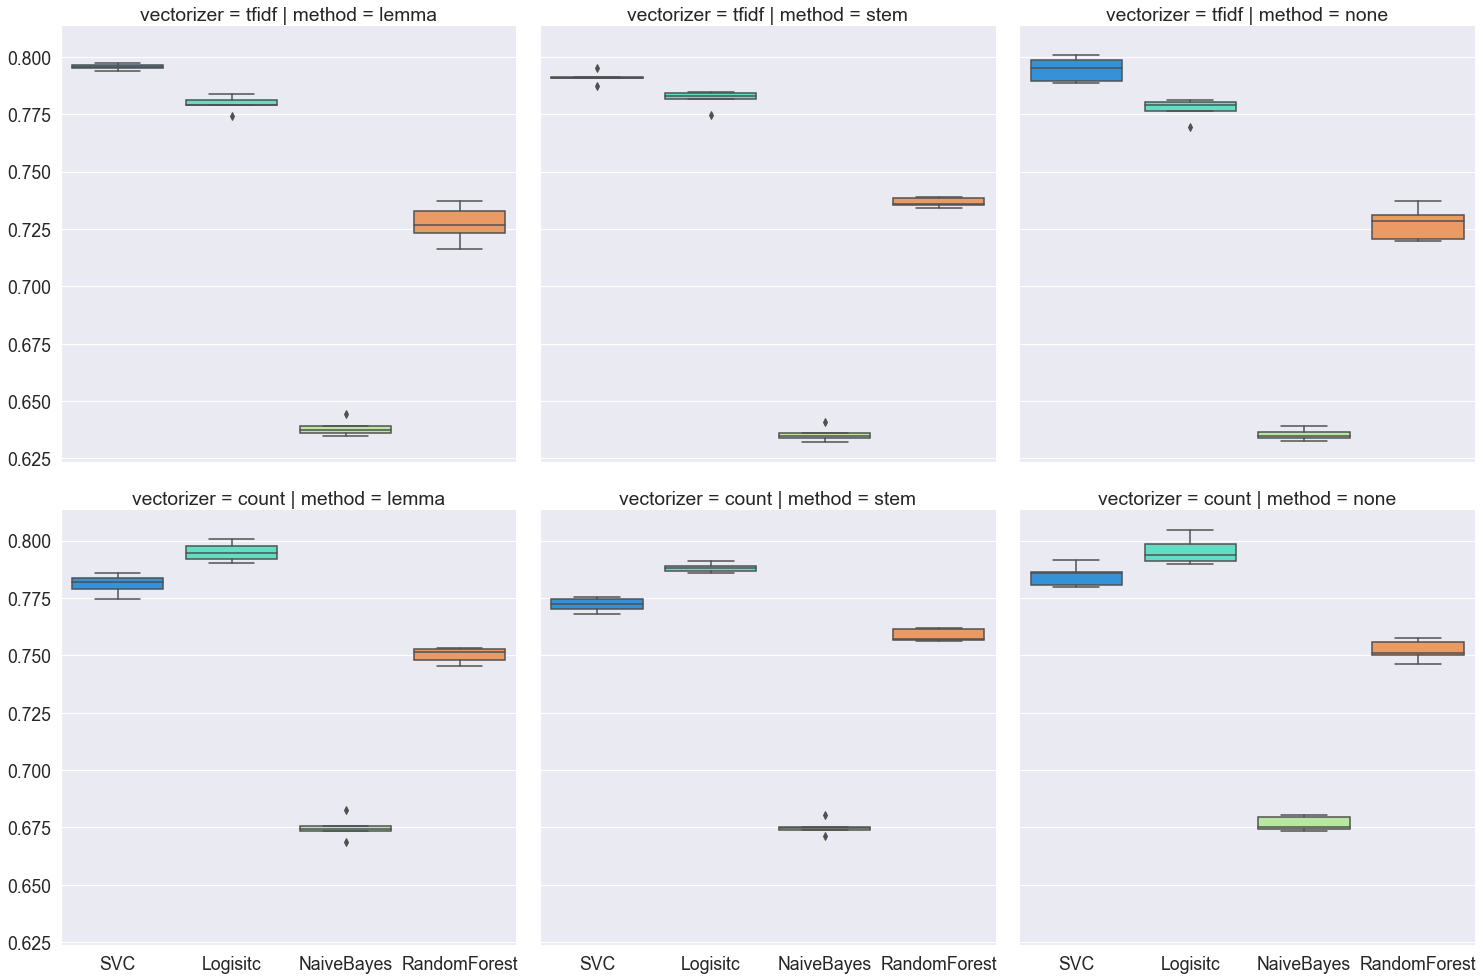

In [260]:
sns.set(font_scale = 1.6)
g = sns.FacetGrid(all_df, col = 'method', row = 'vectorizer', height = 7)
g.map_dataframe(sns.boxplot, x = 'model_name', y = 'accuracy', palette = 'rainbow')

In [261]:
accuracies = all_df.groupby(['model_name', 'method', 'vectorizer']).accuracy.mean()
stdDev = all_df.groupby(['model_name', 'method', 'vectorizer']).accuracy.std()
metrics_df = pd.concat([accuracies, stdDev], axis = 1, ignore_index = True)
metrics_df.columns = ['mean_acc', 'mean_std']

In [262]:
metrics_df.sort_values(by = ['mean_acc','method'], ascending = False)

mean_acc  mean_std
model_name   method vectorizer                    
Logisitc     none   count       0.795626  0.006088
SVC          lemma  tfidf       0.795596  0.001404
Logisitc     lemma  count       0.795049  0.004253
SVC          none   tfidf       0.794594  0.005344
             stem   tfidf       0.790979  0.002756
Logisitc     stem   count       0.788094  0.002062
SVC          none   count       0.784844  0.004830
Logisitc     stem   tfidf       0.781564  0.004161
SVC          lemma  count       0.781017  0.004396
Logisitc     lemma  tfidf       0.779408  0.003472
             none   tfidf       0.777251  0.004782
SVC          stem   count       0.772058  0.003105
RandomForest stem   count       0.758633  0.002772
             none   count       0.752134  0.004575
             lemma  count       0.750129  0.003387
             stem   tfidf       0.736674  0.002052
             none   tfidf       0.727441  0.007266
             lemma  tfidf       0.727168  0.008111
NaiveBayes   none   count       0.676507  0.003224
             stem   count       0.675110  0.003285
             lemma  count       0.674837  0.005102
                    tfidf       0.638269  0.003783
             stem   tfidf       0.635505  0.003233
             none   tfidf       0.635323  0.002499

In [ ]:
#this chart works but seaborn actually looks better, and has consistent y labelling across grid.

#worthwhile learning though!

#fig = make_subplots(rows = 3, cols = 1, subplot_titles = ('None', 'Stem', 'Lemma'),)

#fig.add_trace(go.Box(x = count_df['model_name'], y = count_df['accuracy'], name = 'count'), row = 1, col = 1)
#fig.add_trace(go.Box(x = tfidf_df['model_name'], y = tfidf_df['accuracy'], name = 'tfidf'), row = 1, col = 1)
#fig.add_trace(go.Box(x = stem_tfidf_df['model_name'], y = stem_tfidf_df['accuracy'], name = 'tfidf_stem'), row = 2, col = 1)
#fig.add_trace(go.Box(x = stem_count_df['model_name'], y = stem_count_df['accuracy'], name = 'count_stem'), row = 2, col = 1)
#fig.add_trace(go.Box(x = lemma_tfidf_df['model_name'], y = lemma_tfidf_df['accuracy'], name = 'tfidf_lemma'), row = 3, col = 1)
#fig.add_trace(go.Box(x = lemma_count_df['model_name'], y = lemma_count_df['accuracy'], name = 'count_lemma'), row = 3, col = 1)
#fig.update_traces(boxpoints='all', jitter=0)
#fig.show()